# Blind deconvolution

In [1]:
import sys
import os
# sys.path.insert(1, 'C:/Users/Johan/Documents/FAU_Masterarbeit/Implementation')
sys.path.insert(1, 'C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites')
from deconv import REGISTRY
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
pd.options.mode.chained_assignment = None
from matplotlib.colors import LogNorm
import imagequalitymetrics as iqm
import tifffile as tif
from scipy.signal import convolve
from skimage import io
from Neighbor2Neighbor import Neighbor2Neighbor
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.restoration import denoise_bilateral
import os
from skimage import io
import numpy as np
import tifffile as tif

In [2]:
MAX_VAL = 12870
MIN_VAL = -2327

def _rescale(img):
    img = (img - MIN_VAL)
    return img / MAX_VAL

def snr(a):
    a = np.asanyarray(a)
    m = a.mean()
    sd = a.std()
    return np.where(sd == 0, 0, m/sd)

## 1. Preprocessing: Denoising

### 1.1 Effect on raw data

### 1.1.1 Obtain results

#### 1.1.1.1 Gaussian Smoothing

Has Hyperparameter σ --> how does it effect the raw data? 

In [38]:
# reduced DS
path= '../Registered/Heatmap'
files = [f for f in os.listdir(path) if f.endswith('.tif')]
deconvolver = REGISTRY['BlindRL'](args)
sigma = np.arange(0 ,4.1, 0.5)
gaussian = './Raw_gaussian'

if not os.path.exists(res_path):
    os.makedirs(res_path)

for (i, f) in enumerate(files):
    for (j, s) in enumerate(sigma):
        img = np.float32(io.imread(os.path.join(path, f)))
        ix=deconvolver.preprocess(img, s)
        tif.imsave(os.path.join(gaussian, str(s) + f), ix)

#### 1.1.1.2 Neighbor2Neighbor

Huang, Tao, et al. "Neighbor2Neighbor: Self-Supervised Denoising from Single Noisy Images." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.

In [3]:
n2n_path='C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites/Evaluation/n2n'
denoiser = Neighbor2Neighbor()
denoiser.predict(checkpoint_dir='C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites/Neighbor2Neighbor/results/unet_gauss25_b4e100r02/2021-12-02-16-30/epoch_model_050.pth',
                input='C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites/Registered/Heatmap',
                res_path = n2n_path)

#### 1.1.1.3 Bilateral Filter

Huang, Tao, et al. "Neighbor2Neighbor: Self-Supervised Denoising from Single Noisy Images." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.

In [23]:
path = '../Registered/Heatmap'
res_path = 'bilateral_filter'
if not os.path.exists(res_path):
    os.makedirs(res_path)

files = [f for f in os.listdir(path) if f.endswith('.tif')]
for f in files:
    noisy = io.imread(os.path.join(path, f))
    res = np.zeros(noisy.shape)
    diff =np.zeros(noisy.shape)
    for i in range(noisy.shape[0]):
        # xt = _rescale(noisy[i,:,:])
        xt = noisy[i,:,:]
        xt -=MIN_VAL
        x = denoise_bilateral(xt)
        res[i,:,:]= x
        diff[i,:,:] = x - xt
    tif.imsave(os.path.join(res_path, f), res)
    tif.imsave(os.path.join(res_path, f[:-4]+ '_diff.tif'), diff)

### 1.1.2 Comparison

#### 1.1.2.1 Visual inspection

Alessandro_520_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif


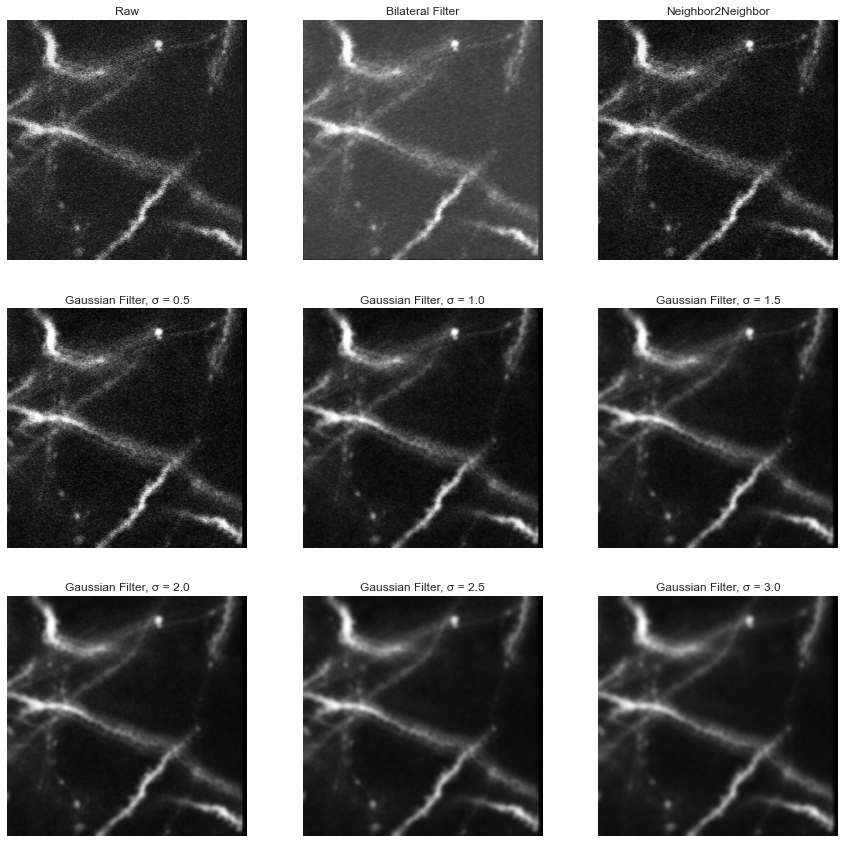

In [24]:
img1 = 'Alessandro_520_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif'
plane = 11

print("\033[1m" + img1 + "\033[0m")
fig=plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

#Raw
f = io.imread(os.path.join(path, img1))
ax = fig.add_subplot(3, 3, 1)
ax.imshow(f[plane, :, :],cmap='gray')
ax.set_title('Raw')
ax.axis('off')

# Bilateral
f = io.imread(os.path.join(res_path, img1))
ax = fig.add_subplot(3, 3, 2)
ax.imshow(f[plane, :, :],cmap='gray')
ax.set_title('Bilateral Filter')
ax.axis('off')
              
# N2N
f = io.imread(os.path.join(n2n_path, img1))
ax = fig.add_subplot(3, 3, 3)
ax.imshow(f[plane, :, :],cmap='gray')
ax.set_title('Neighbor2Neighbor')
ax.axis('off')

sigmas = np.arange(0.5,3.1,0.5)
for (i,l) in enumerate(sigmas):
    f = io.imread(os.path.join(gaussian, str(l) + img1))
    ax = fig.add_subplot(3, 3, i+4)
    ax.imshow(f[plane, :, :], cmap='gray')
    ax.set_title('Gaussian Filter, σ = ' + str(l))
    ax.axis('off')

plt.show()     

#### 1.1.2.2 Scatter Plot
How does the SNR change for different values 

In [25]:
path = '../Registered/Heatmap'
bil_path = 'bilateral_filter'
gaussian = 'Raw_gaussian'
n2n_path = 'n2n'
sigma = '2.0'

files = [f for f in os.listdir(path) if f.endswith('.tif')]

res = np.zeros((len(files),4))

for (i,file) in enumerate(files):
    p_raw=io.imread(os.path.join(path, file))
    p_raw = _rescale(p_raw)
    print(np.min(p_raw), np.max(p_raw))

    p_bil=io.imread(os.path.join(bil_path, file))
    p_bil /= (MAX_VAL -MIN_VAL)
    print(np.min(p_bil), np.max(p_bil))

    p_gau=io.imread(os.path.join(gaussian, sigma+file))
    #p_gau = _rescale(p_gau)
    print(np.min(p_gau), np.max(p_gau))
    p_n2n=io.imread(os.path.join(n2n_path, file))
    p_n2n /= (MAX_VAL -MIN_VAL)
    print(np.min(p_n2n), np.max(p_n2n))

    res[i,:] = np.array([snr(p_raw), snr(p_bil), snr(p_gau), snr(p_n2n)])


0.09458625277717074 0.8968081506167443
0.024541911452483193 0.6967134801713588
0.18080819 0.7730524
0.12856334142326611 0.7281553179698296
0.08501185229700854 0.9021200587606838
0.00648942779799564 0.707447957683915
0.18080808 0.7828263
0.12927522412678077 0.7248685364504508
0.10595895193673514 0.8988808608925797
0.007858335387508767 0.7086359747548278
0.1808084 0.80625445
0.12857055463249326 0.7154914287153714
0.0355091062366453 0.9176156850961539
0.004741805558917084 0.728887646253578
0.17909086 0.7708885
0.11026526906266451 0.7272892830410608
0.04672541407160548 0.9290196890782828
0.002115227103476395 0.7345040957994864
0.17822513 0.7923245
0.09161402255584984 0.7271598629663749
0.04849522493565462 0.9769088116744367
0.004800824274354715 0.7968683519428573
0.18081163 0.81472915
0.10526592066125304 0.7497357619924985
0.020024027079691142 0.9852086823766512
0.00044666808814773694 0.7862013123663487
0.1793836 0.81706434
0.06734250527961934 0.7506814795888991
0.09159652603256119 0.94115

In [26]:
import pandas as pd
r_reshaped =np.append(res[:,0:2], res[:,[0,2]], axis=0)
r_reshaped = np.append(r_reshaped, res[:,[0,3]], axis=0)
print(r_reshaped.shape)
df = pd.DataFrame(r_reshaped, columns=['Raw', 'Denoised'])
lab = ['Bilateral Filter']*len(files)
lab=lab+(['Gaussian Filter ( σ = 2.0)']*len(files))
lab=lab+(['Neighbor2Neighbor']*len(files))
df['Name'] = lab

(30, 2)


In [27]:
df.head()

,Raw,Denoised,Name
0,3.475434,4.007704,Bilateral Filter
1,3.028274,3.758082,Bilateral Filter
2,2.443307,2.683981,Bilateral Filter
3,2.576269,3.031826,Bilateral Filter
4,2.345815,2.712226,Bilateral Filter


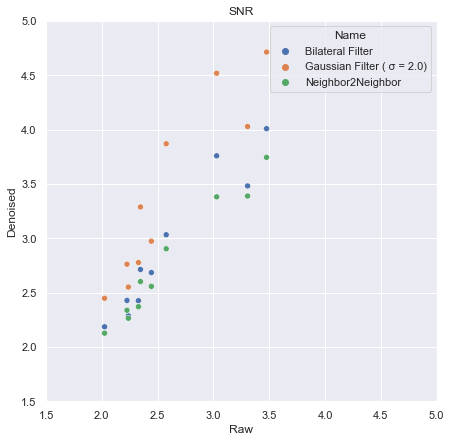

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(7,7)})
sns.scatterplot(data=df, x="Raw", y="Denoised", hue="Name")
plt.title('SNR')
plt.xlim(1.5,5)
plt.ylim(1.5,5)
plt.savefig('scatter_denoising_pre_deconv.svg')

### 1.2 Effect on deconvolution

### 1.2.1 Obtain results

#### 1.2.1.1 Gaussian Smoothing

In [76]:
args = {}
args['data_path']= ''
args['source_folder']= '../Registered/Heatmap'
args['target_folder']= ''
args['psf'] = "../PSF"

sig = np.arange(0.5,4.1,0.5)
for s in sig:
    args['result_path'] = 'Blind_RL_Sigma/' + str(s)
    print(s)
    blind_rl = REGISTRY['BlindRL'](args)
    blind_rl.predict(args['source_folder'], 7, 5, 3, s, eval_img_steps = False, save_intermediate_res= False, parallel=True)

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0


#### 1.2.1.2 Neighbor2Neighbor

In [2]:
args = {}
args['data_path']= ''
args['source_folder']= './n2n'
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'Blind_RL_N2N/'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 7, 5, 3, sigma=0.0, eval_img_steps = False, save_intermediate_res= False, parallel=True, preprocess= False)

#### 1.2.1.3 Bilateral Filter

In [19]:
args = {}
args['data_path']= ''
args['source_folder']= './bilateral_filter'
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'Blind_RL_Bil/'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 7, 5, 3, sigma=0.0, eval_img_steps = False, save_intermediate_res= False, parallel=True, preprocess= False)

### 1.2.2 Evaluation

#### 1.2.2.1 Visual inspection

Alessandro_514_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A1.tif


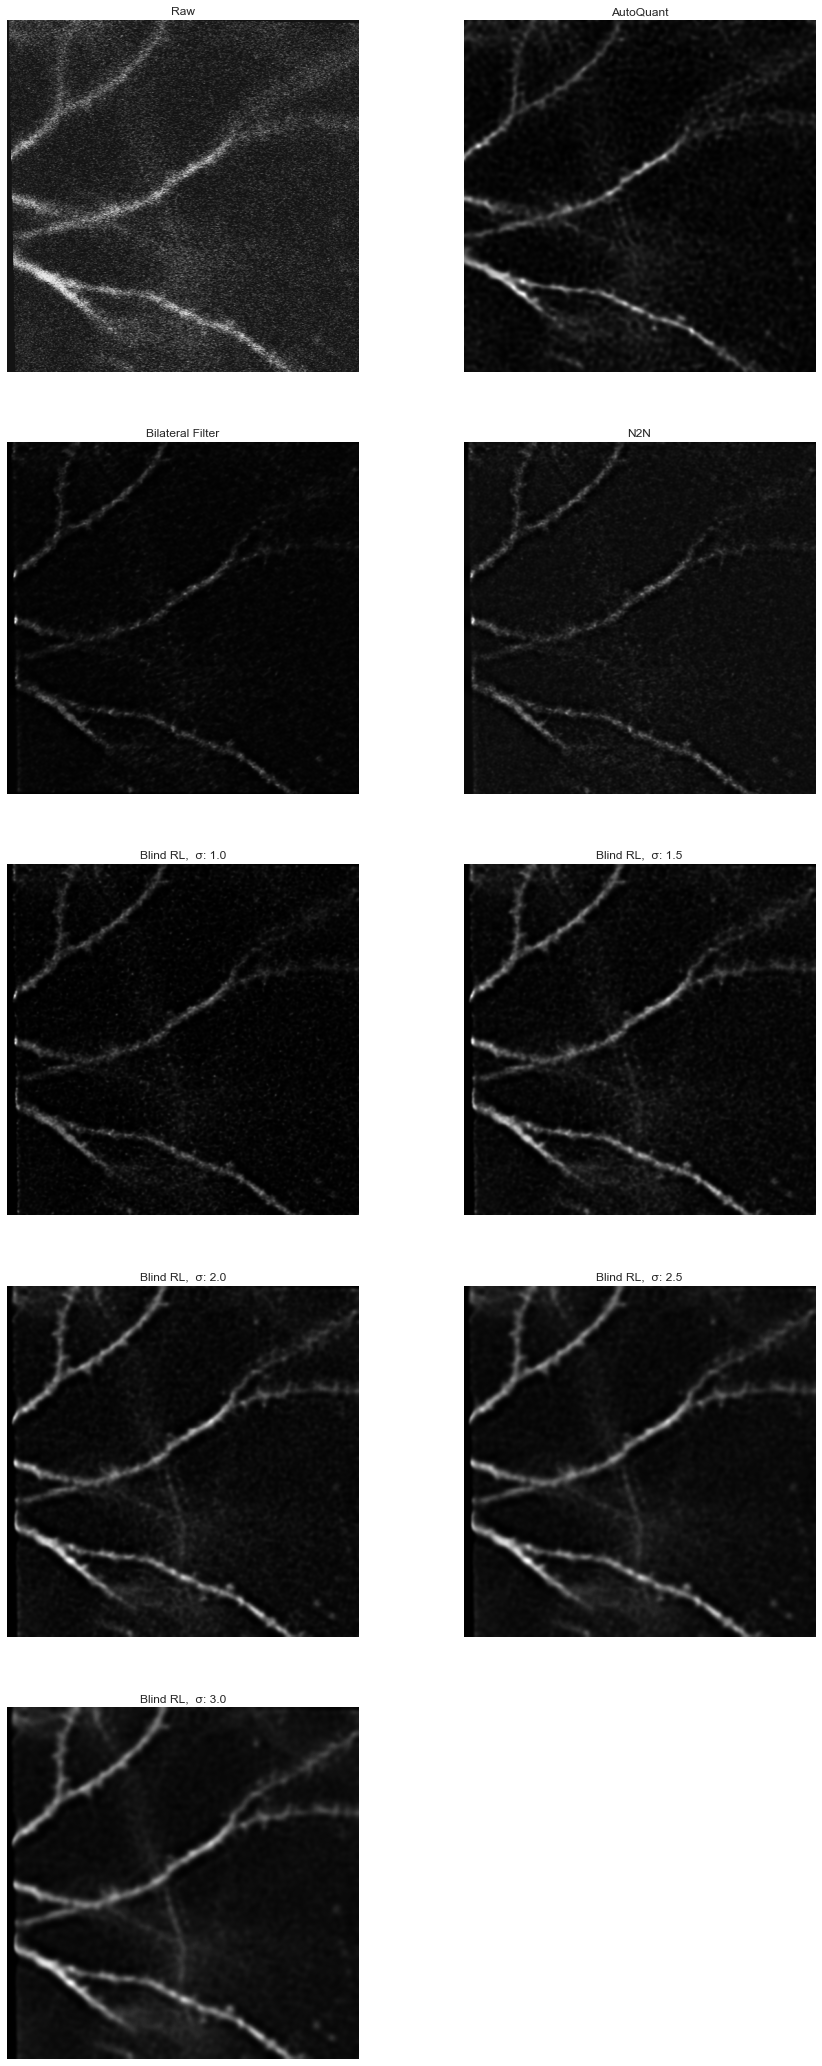

In [34]:
img1 = 'Alessandro_514_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A1.tif'
plane = 44
blind_rl_res = './Blind_RL_Sigma'
autoquant_res='D:/jo77pihe/Registered/Deconved_AutoQuant_R2'
raw = "D:/jo77pihe/Registered/Raw"
n2n_res = './Blind_RL_N2N'
bil_res = './Blind_RL_Bil/'


print("\033[1m" + img1 + "\033[0m")
fig=plt.figure()
fig.set_figheight(37.5)
fig.set_figwidth(15)

n_h = 5
n_w = 2
#Raw
f = io.imread(os.path.join(raw, img1))
ax = fig.add_subplot(n_h, n_w, 1)
ax.imshow(f[plane, :, :],cmap='gray')
ax.set_title('Raw')
ax.axis('off')

# AUtoQuant Img
f = io.imread(os.path.join(autoquant_res, img1))
ax = fig.add_subplot(n_h, n_w, 2)
ax.imshow(f[plane, :, :],cmap='gray')
ax.set_title('AutoQuant')
ax.axis('off')

#bilateral img
f = io.imread(os.path.join(bil_res, img1))
ax = fig.add_subplot(n_h, n_w, 3)
ax.imshow(f[plane, :, :],cmap='gray')
ax.set_title('Bilateral Filter')
ax.axis('off')
              
# n2n Img
f = io.imread(os.path.join(n2n_res, img1))
ax = fig.add_subplot(n_h, n_w, 4)
ax.imshow(f[plane, :, :],cmap='gray')
ax.set_title('N2N')
ax.axis('off')

sm = ['1.0', '1.5', '2.0', '2.5', '3.0']
for (i,l) in enumerate(sm):
    #Blind RL img
    f = io.imread(os.path.join(blind_rl_res,l, img1))
    ax = fig.add_subplot(n_h, n_w, i+5)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('Blind RL,  σ: ' + l)
    ax.axis('off')

plt.show()

#### 1.2.2.2 Quantitative evaluation: SNR

*SNR*

In [6]:
path = '../Registered/Heatmap'
bil_path = './Blind_RL_Bil/'
gaussian = './Blind_RL_Sigma'
n2n_path = './Blind_RL_N2N'
sigma = '2.0'

files = [f for f in os.listdir(path) if f.endswith('.tif')]

res = np.zeros((len(files),4))

for (i,file) in enumerate(files):
    p_raw=io.imread(os.path.join(path, file))
    # p_raw = _rescale(p_raw)
    p_bil=io.imread(os.path.join(bil_path, file))
    # p_bil = _rescale(p_bil)
    p_gau=io.imread(os.path.join(gaussian, sigma,file))
    # p_gau = _rescale(p_gau)
    p_n2n=io.imread(os.path.join(n2n_path, file))
    # p_n2n = _rescale(p_n2n)
    res[i,:] = np.array([snr(p_raw), snr(p_bil), snr(p_gau), snr(p_n2n)])

In [7]:
import pandas as pd
r_reshaped =np.append(res[:,0:2], res[:,[0,2]], axis=0)
r_reshaped = np.append(r_reshaped, res[:,[0,3]], axis=0)
print(r_reshaped.shape)
df = pd.DataFrame(r_reshaped, columns=['Raw', 'Denoised'])
lab = ['Bilateral Filter']*len(files)
lab=lab+(['Gaussian Filter (σ = 2.0)']*len(files))
lab=lab+(['Neighbor2Neighbor']*len(files))
df['Name'] = lab

(30, 2)


(0.25, 2.2)

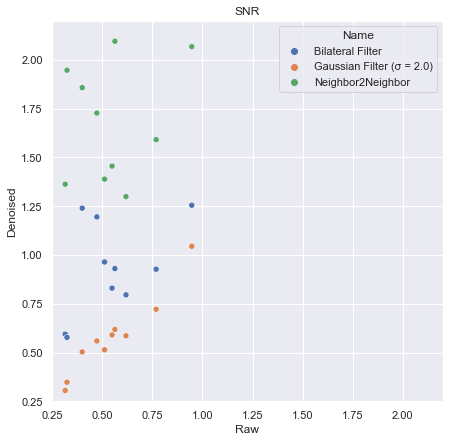

In [8]:
sns.set(rc={'figure.figsize':(7,7)})
sns.scatterplot(data=df, x="Raw", y="Denoised", hue="Name")
plt.title('SNR')
plt.xlim(0.25,2.2)
plt.ylim(0.25,2.2)

#### 1.2.2.3 Quantitative evaluation: Reconstruction Error

In [35]:
bil_p = './bilateral_filter'
bil_d='./Blind_RL_Bil'
n2n_p = './n2n'
n2n_d='./Blind_RL_N2N'
g_p = './Raw_gaussian'
g_d='./Blind_RL_Sigma'

In [52]:
deconvolver = REGISTRY['BlindRL'](args)

def calc(preprocessed_path, deconved_path, f, sigma=None):
    if sigma is None:
        preprocessed = tif.imread(os.path.join(preprocessed_path, f))
        preprocessed /= (MAX_VAL)

    else:
        preprocessed = tif.imread(os.path.join(preprocessed_path, sigma + f))
    print(np.min(preprocessed),np.max(preprocessed))
    img = tif.imread(os.path.join(deconved_path,f))
    psf = tif.imread(os.path.join(deconved_path, f[:-4]+'_psf.tif'))
    psf = deconvolver._pad(psf)
    img = deconvolver._pad(img)
    convolved = convolve(img, psf, mode='same')
    convolved = deconvolver._unpad(convolved)
    if np.max(1000) >3:
                convolved /= (MAX_VAL -MIN_VAL)

    print(np.min(convolved),np.max(convolved))
    return preprocessed, convolved

In [53]:
metrics = iqm.ImageQualityMetrics()
sigma = '2.0'
# PSNR, SSIM, MSE
files = [f for f in os.listdir(path) if (f.endswith('.tif') and (not 'psf' in f))]

result = np.zeros((len(files),3,3))

for (j,f) in enumerate(files):
    # Bil filter
    preprocessed, convolved = calc(bil_p, bil_d, f)
    result[j,0,0]= metrics.psnr(preprocessed, convolved)
    result[j,0,1]= metrics.ssim(preprocessed, convolved)
    result[j,0,2]= metrics.mse(preprocessed, convolved)
    
    # Bil filter
    preprocessed, convolved = calc(n2n_p, n2n_d, f)
    result[j,1,0]= metrics.psnr(preprocessed, convolved)
    result[j,1,1]= metrics.ssim(preprocessed, convolved)
    result[j,1,2]= metrics.mse(preprocessed, convolved)
    
    # Gaussian
    preprocessed, convolved = calc(g_p, g_d+'/'+ sigma,f, sigma ='2.0')
    result[j,2,0]= metrics.psnr(preprocessed, convolved)
    result[j,2,1]= metrics.ssim(preprocessed, convolved)
    result[j,2,2]= metrics.mse(preprocessed, convolved)

0.02897928736156854 0.822684907394261
4.093895400937059e-11 1.7715383556136955e-09
0.15180863244828088 0.8598116835421523
0.1341390598949815 0.7753501439401199
0.18080819 0.7730524
5.580285383174693e-12 3.0612160813741317e-09


C:\Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites\imagequalitymetrics.py:63: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  return sk_psnr(gt_img, img)
C:\Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites\imagequalitymetrics.py:42: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  val = sk_ssim(img, gt_img)


0.007662768783693842 0.83536026518434
3.984393150845518e-11 1.2387215508088206e-09
0.15264922929717853 0.8559306253642192
0.1188693027719691 0.7975856559331558
0.18080808 0.7828263
4.640116795286379e-12 1.705773158118883e-09
0.009279185927270454 0.8367630853418118
2.7793934437947655e-11 1.0189906426318618e-09
0.15181714986402486 0.8448580607760295
0.1184071956473986 0.7632723213757797
0.1808084 0.80625445
7.0763206612110634e-12 1.624404396914402e-09
0.00559916232158997 0.8606764226974067
1.1569079921342206e-10 1.675445713474266e-09
0.13020212074167153 0.8587890625
0.13946472977369126 0.7507485409309044
0.17909086 0.7708885
3.297420225605986e-12 3.861469231330898e-09
0.0024976772565291974 0.8673083717066663
7.711565570651788e-11 1.174731501276621e-09
0.10817857814928128 0.8586362422299922
0.11473299000751576 0.7553588745928694
0.17822513 0.7923245
1.7636547939840483e-12 2.444508480112517e-09
0.005668852097697638 0.9409485893143436
4.3037479446689854e-11 2.22238939473905e-09
0.1242988497

In [54]:
import pandas as pd
r_reshaped =np.append(result[:,0,:], result[:,1,:], axis=0)
r_reshaped = np.append(r_reshaped, result[:,2,:], axis=0)
print(r_reshaped.shape)
df = pd.DataFrame(r_reshaped, columns=['PSNR', 'SSIM', 'MSE'])
lab = ['Bilateral Filter']*len(files)
lab=lab+(['Gaussian Filter (σ = 2.0)']*len(files))
lab=lab+(['Neighbor2Neighbor']*len(files))
df['Denoising'] = lab

(30, 3)


#### PSNR

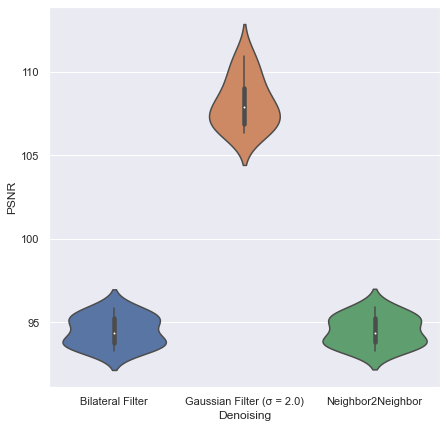

In [55]:
ax = sns.violinplot(x="Denoising", y="PSNR", data=df)

*SSIM*
TODO: Violin Plot

In [23]:
ax = sns.violinplot(x="SSIM", y="Denoising", data=df)

ValueError: Could not interpret input 'SSIM'

*MSE*
TODO: Violin Plot

In [ ]:
ax = sns.violinplot(x="MSE", y="Denoising", data=df)

#### 1.2.2.4 Find best Sigma: Reconstruction error

In [86]:
n_images=10
metrics = iqm.ImageQualityMetrics()
original_path = 'D:/jo77pihe/Registered/Raw'

# PSNR, SSIM, MSE
result = np.zeros((n_images,len(sig),3))
deconvolver = REGISTRY['BlindRL'](args)

for (i,s) in enumerate(sig):
    path = 'Blind_RL_Sigma/' + str(s)
    files = [f for f in os.listdir(path) if (f.endswith('.tif') and (not 'psf' in f))]
    for (j,f) in enumerate(files):
        org = tif.imread(os.path.join(original_path, f))
        org_sm = blind_rl.preprocess(org, s)
        img = tif.imread(os.path.join(path,f))
        psf = tif.imread(os.path.join(path, f[:-4]+'_psf.tif'))
        psf = deconvolver._pad(psf)
        img = deconvolver._pad(img)
        convolved = convolve(img, psf, mode='same')
        convolved = deconvolver._unpad(convolved)
        result[j,i,0]= metrics.psnr(org_sm, convolved)
        result[j,i,1]= metrics.ssim(org_sm, convolved)
        result[j,i,2]= metrics.mse(org_sm, convolved)

In [91]:
np.save('best_sigma_eval.npy', result)

 *PSNR*

Text(0, 0.5, 'PSNR')

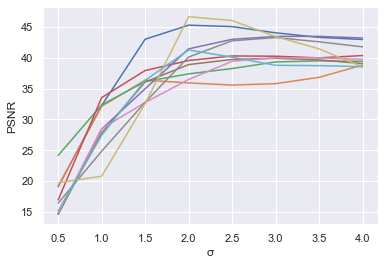

In [88]:
for i in range(result.shape[0]):
    plt.plot(sig,result[i,:,0])

plt.xlabel('σ')
plt.ylabel('PSNR')

*SSIM*

Text(0, 0.5, 'SSIM')

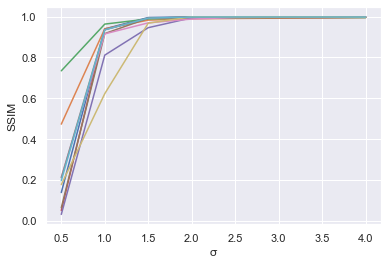

In [89]:
for i in range(result.shape[0]):
    plt.plot(sig,result[i,:,1])

plt.xlabel('σ')
plt.ylabel('SSIM')

*MSE*

Text(0, 0.5, 'MSE')

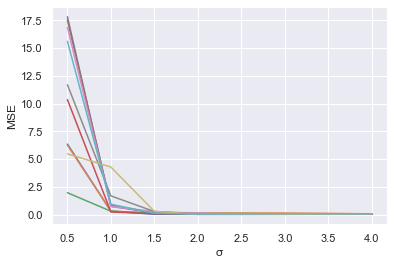

In [90]:
for i in range(result.shape[0]):
    plt.plot(sig,result[i,:,2])

plt.xlabel('σ')
plt.ylabel('MSE')

# 2. Find best Hyperparameters

### 2.1 Evaluate all hyperparameter combinations

Evaluate BL with number of inner loop iterations *i_psf, i_img = [1,....,5]* and outer iterations *i_rl = [1,...,10]*

#### 2.1.1 Obtain results

In [5]:
args = {}
args['data_path']= ''
args['source_folder']= '..\\Registered\\Heatmap_reduced'
args['target_folder']= ''
args['result_path'] = '..\\Blind_RL\\Heatmap_HypParamEval'
args['psf'] = "C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites/PSF"

max_iter_inner = 5
max_iter_outer = 10
sigma = 2

In [4]:
blind_rl = REGISTRY['BlindRL'](args)

In [5]:
for i_psf in range(3,max_iter_inner+1):
    for i_img in range(1,max_iter_inner+1):
        if i_psf==3 and i_img<=2:
            continue
        else:
            blind_rl.predict(args['source_folder'], max_iter_outer, i_img, i_psf, sigma, eval_img_steps = True, save_intermediate_res = True)

*Create data structure with all results*

In [3]:
from skimage.filters import gaussian

def preprocess(img, sigma=1):
    img = gaussian(img, sigma=sigma)
    return img

def _pad(img, pixels=20, planes=10):
    """
    Pad image
    :param img: Original image (np.array)
    :param pixels: amount to pad in x and y direction
    :param planes: amount to pad in z direction
    :return: padded image
    """
    return np.pad(img, ((planes, planes), (pixels, pixels), (pixels, pixels)), 'reflect')

def _unpad(img, pixels=20, planes=10):
    '''
    Crop the image by the number of pixels specified in x and y direction, by the amount of planes in z direction.
    :param img: Input image
    :param pixels: Image is reduced by the number of pixels specified in x and y direction on both sides
    :param planes: Image is reduced by the number of planes specified in z direction on both sides
    :return: Cropped image
    '''

    pixels = int(pixels)
    planes = int(planes)
    (z, x, y) = img.shape
    return img[planes:z - planes, pixels:x - pixels, pixels:y - pixels]

In [10]:
metrics = iqm.ImageQualityMetrics()
sig = 2
iter_rl= np.tile(np.repeat(np.arange(1,max_iter_outer+1), (max_iter_inner)), max_iter_inner)
iter_img= np.tile(np.arange(1,max_iter_inner+1), max_iter_inner*max_iter_outer)
iter_psf= np.repeat(np.arange(1,max_iter_inner+1), max_iter_inner*max_iter_outer)

original_path = '..\\Registered\\Heatmap_reduced'
res_path = 'D:\\jo77pihe\\Registered\\Blind_RL_Heatmap'

files = [f for f in os.listdir(original_path) if f.endswith('.tif') and (not 'psf' in f)]

In [12]:
lx = len(iter_rl)
df = pd.DataFrame()
df['Iter_RL'] = iter_rl#np.tile(iter_rl, len(files))
df['Iter_IMG'] = iter_img#np.tile(iter_img, len(files))
df['Iter_PSF'] = iter_psf#np.tile(iter_psf, len(files))
# names =  [f for f in files for i in range(lx)]
# df['File'] = names

df['psnr'] = np.zeros((len(df),1))
df['ssim'] = np.zeros((len(df),1))
df['mse'] = np.zeros((len(df),1))

for idx in range(0,len(df)):
    psnr = 0
    ssim = 0
    mse=0
    for fx in files:
        f = str(iter_rl[idx])+str(iter_psf[idx])+str(iter_img[idx])+ str(fx)
        img = np.float32(io.imread(os.path.join(res_path, f)))
        psf = np.float32(io.imread(os.path.join(res_path, f[:-4]+'_psf.tif')))

        org = np.float32(io.imread(os.path.join(original_path, fx)))
        org_sm = preprocess(org, sig)
        
        psf = _pad(psf)
        img = _pad(img)
        convolved = convolve(img, psf, mode='same')
        convolved =_unpad(convolved)

        # Scaling
        org_sm = _rescale(org_sm)
        org_sm = np.clip(org_sm, 0,1)
        convolved -= np.min(convolved)
        convolved = (convolved/np.max(convolved))*(np.max(org_sm))
        
        psnr += metrics.psnr(org_sm, convolved)
        ssim += metrics.ssim(org_sm, convolved)
        mse += metrics.mse(org_sm, convolved)

    df.loc[[idx],['psnr']]= psnr/len(files)
    df.loc[[idx],['ssim']]= ssim/len(files)
    df.loc[[idx],['mse']]= mse/len(files)
    print(idx)

x
x
x
x
x
0
x
x
x
x
x
1
x
x
x
x
x
2
x
x
x
x
x
3
x
x
x
x
x
4
x
x
x
x
x
5
x
x
x
x
x
6
x
x
x
x
x
7
x
x
x
x
x
8
x
x
x
x
x
9
x
x
x
x
x
10
x
x
x
x
x
11
x
x
x
x
x
12
x
x
x
x
x
13
x
x
x
x
x
14
x
x
x
x
x
15
x
x
x
x
x
16
x
x
x
x
x
17
x
x
x
x
x
18
x
x
x
x
x
19
x
x
x
x
x
20
x
x
x
x
x
21
x
x
x
x
x
22
x
x
x
x
x
23
x
x
x
x
x
24
x
x
x
x
x
25
x
x
x
x
x
26
x
x
x
x
x
27
x
x
x
x
x
28
x
x
x
x
x
29
x
x
x
x
x
30
x
x
x
x
x
31
x
x
x
x
x
32
x
x
x
x
x
33
x
x
x
x
x
34
x
x
x
x
x
35
x
x
x
x
x
36
x
x
x
x
x
37
x
x
x
x
x
38
x
x
x
x
x
39
x
x
x
x
x
40
x
x
x
x
x
41
x
x
x
x
x
42
x
x
x
x
x
43
x
x
x
x
x
44
x
x
x
x
x
45
x
x
x
x
x
46
x
x
x
x
x
47
x
x
x
x
x
48
x
x
x
x
x
49
x
x
x
x
x
50
x
x
x
x
x
51
x
x
x
x
x
52
x
x
x
x
x
53
x
x
x
x
x
54
x
x
x
x
x
55
x
x
x
x
x
56
x
x
x
x
x
57
x
x
x
x
x
58
x
x
x
x
x
59
x
x
x
x
x
60
x
x
x
x
x
61
x
x
x
x
x
62
x
x
x
x
x
63
x
x
x
x
x
64
x
x
x
x
x
65
x
x
x
x
x
66
x
x
x
x
x
67
x
x
x
x
x
68
x
x
x
x
x
69
x
x
x
x
x
70
x
x
x
x
x
71
x
x
x
x
x
72
x
x
x
x
x
73
x
x
x
x
x
74
x
x
x
x
x
75
x
x
x
x
x
76
x
x
x
x
x

In [15]:
df.to_pickle("heatmap.pkl")

In [13]:
df

,Iter_RL,Iter_IMG,Iter_PSF,psnr,ssim,mse
0,1,1,1,100.623741,0.805338,10.467486
1,1,2,1,103.084919,0.790750,5.880983
2,1,3,1,103.059577,0.748004,5.942123
3,1,4,1,102.647893,0.710431,6.523804
4,1,5,1,102.210144,0.677402,7.187025
...,...,...,...,...,...,...
245,10,1,5,96.328734,0.009071,28.002855
246,10,2,5,96.327965,0.008820,28.009042
247,10,3,5,96.327967,0.008819,28.009025
248,10,4,5,96.327971,0.008820,28.008992


#### 2.1.2 Plot result

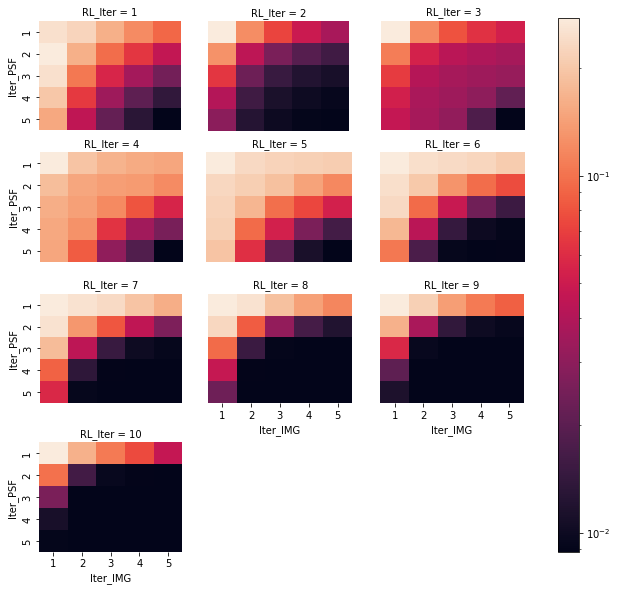

In [17]:
fig = plt.figure()
vmin = df.values.min()
vmax = df.values.max()

for i in range(max_iter_outer):
    ax = fig.add_subplot(4, 3, i+1)
    df_i = df.loc[df['Iter_RL'] == i+1]
    # df_sub = df_i.iloc[i*(max_iter_inner**2): (i+1)*(max_iter_inner**2)]
    df_i.drop(columns='Iter_RL', inplace=True)
    # r = np.reshape(np.array(df_sub['snr'], (max_iter_inner, max_iter_inner))
    df_pivot = df_i.pivot("Iter_PSF", "Iter_IMG", "ssim")
    # df_pivot = df_i.groupby(['Iter_IMG', 'Iter_PSF']).mean().unstack(level=0)
    if i == 5:
        sns.heatmap(df_pivot, vmin=vmin, vmax=vmax, norm=LogNorm(), cbar=True,
                    cbar_kws = dict(use_gridspec=False, pad=0.01, shrink=2.25),
                    xticklabels=False,
                    yticklabels=False)
        cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.01, shrink=0.25)
    else:
        sns.heatmap(df_pivot, vmin=vmin, vmax=vmax, norm=LogNorm(), cbar=False, yticklabels=True if i%3==0 else False,
                    xticklabels=True if i ==9 or i == 7 or i == 8 else False)
    ax.set_title('RL_Iter = ' +str(i+1))
    atx = ax
ax = fig.add_subplot(4, 3, 12)
fig.colorbar(atx.collections[0], cax=ax)
#% start: automatic generated code from pylustrator
plt.figure(1).ax_dict = {ax.get_label(): ax for ax in plt.figure(1).axes}
import matplotlib as mpl
plt.figure(1).set_size_inches(25.230000/2.54, 23.090000/2.54, forward=True)
plt.figure(1).ax_dict["<colorbar>"].set_visible(False)
plt.figure(1).axes[0].set_position([0.125000, 0.712609, 0.198356, 0.167391])
plt.figure(1).axes[0].title.set_fontsize(10)
plt.figure(1).axes[0].get_xaxis().get_label().set_visible(False)
plt.figure(1).axes[1].set_position([0.360623, 0.711598, 0.197432, 0.167391])
plt.figure(1).axes[1].title.set_fontsize(10)
plt.figure(1).axes[1].title.set_position([0.500000, 1.006035])
plt.figure(1).axes[1].xaxis.labelpad = -5.440000
plt.figure(1).axes[1].get_xaxis().get_label().set_visible(False)
plt.figure(1).axes[1].get_yaxis().get_label().set_visible(False)
plt.figure(1).axes[2].set_position([0.603643, 0.712609, 0.200205, 0.167391])
plt.figure(1).axes[2].title.set_fontsize(10)
plt.figure(1).axes[2].title.set_position([0.504618, 1.000000])
plt.figure(1).axes[2].yaxis.labelpad = -4.720000
plt.figure(1).axes[2].get_xaxis().get_label().set_visible(False)
plt.figure(1).axes[2].get_yaxis().get_label().set_visible(False)
plt.figure(1).axes[3].set_position([0.125925, 0.511739, 0.200205, 0.167391])
plt.figure(1).axes[3].title.set_fontsize(10)
plt.figure(1).axes[3].get_xaxis().get_label().set_visible(False)
plt.figure(1).axes[4].set_position([0.358775, 0.511739, 0.203903, 0.167391])
plt.figure(1).axes[4].spines['right'].set_visible(False)
plt.figure(1).axes[4].spines['top'].set_visible(False)
plt.figure(1).axes[4].title.set_fontsize(10)
plt.figure(1).axes[4].yaxis.labelpad = -4.000000
plt.figure(1).axes[4].get_xaxis().get_label().set_visible(False)
plt.figure(1).axes[4].get_yaxis().get_label().set_visible(False)
plt.figure(1).axes[5].set_position([0.602305, 0.511739, 0.201543, 0.167391])
plt.figure(1).axes[5].title.set_fontsize(10)
plt.figure(1).axes[5].xaxis.labelpad = -4.720000
plt.figure(1).axes[5].get_xaxis().get_label().set_visible(False)
plt.figure(1).axes[5].get_yaxis().get_label().set_visible(False)
plt.figure(1).axes[7].set_position([0.125925, 0.295716, 0.199281, 0.167391])
plt.figure(1).axes[7].title.set_fontsize(10)
plt.figure(1).axes[7].title.set_position([0.500000, 0.987930])
plt.figure(1).axes[7].xaxis.labelpad = -4.720000
plt.figure(1).axes[7].get_xaxis().get_label().set_visible(False)
plt.figure(1).axes[8].set_position([0.360623, 0.295716, 0.202055, 0.167391])
plt.figure(1).axes[8].title.set_position([0.500000, 1.000000])
plt.figure(1).axes[8].title.set_fontsize(10)
plt.figure(1).axes[8].title.set_position([0.504549, 0.993978])
plt.figure(1).axes[8].get_yaxis().get_label().set_visible(False)
plt.figure(1).axes[9].set_position([0.602305, 0.295716, 0.200205, 0.167391])
plt.figure(1).axes[9].title.set_fontsize(10)
plt.figure(1).axes[9].get_yaxis().get_label().set_visible(False)
plt.figure(1).axes[10].set_position([0.125000, 0.068586, 0.200205, 0.167391])
plt.figure(1).axes[10].title.set_fontsize(10)
plt.figure(1).axes[10].title.set_position([0.504618, 1.000000])
plt.figure(1).axes[11].set_position([0.851144, 0.068315, 0.029166, 0.815951])
#% end: automatic generated code from pylustrator
plt.savefig('Heatmap_var_params.svg')
plt.savefig('Heatmap_var_params.png')
plt.show()

In [11]:
name = os.path.join(args['result_path'], 'results_blind_rl_10_5_1_2.pkl')   
with open(name, 'rb') as file:
    res = pickle.load(file)

In [12]:
res

{'n_iter_outer': 10, 'n_iter_image': 5, 'n_iter_psf': 1, 'sigma': 2}

## 2.2 Find best amount of outer iterations

As the outer iterations seem to be crucial for good results, it is evaluated further for a fixed amount of inner iterations what is the best value.

### 2.2.1 Obtain results

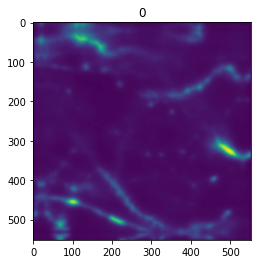

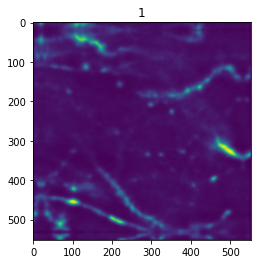

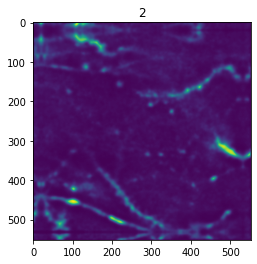

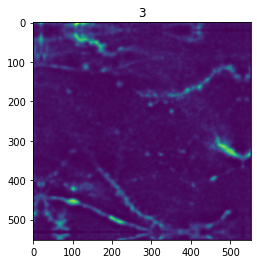

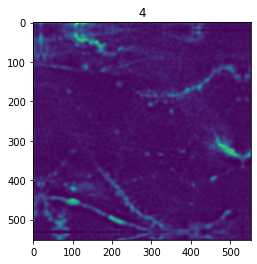

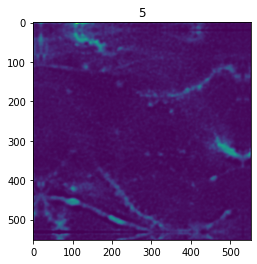

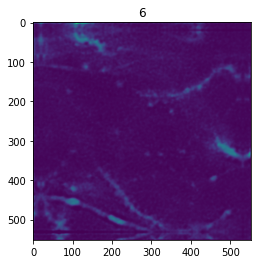

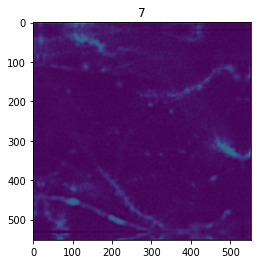

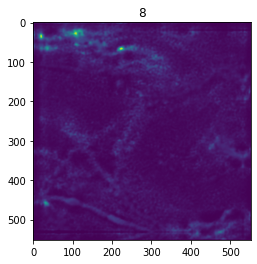

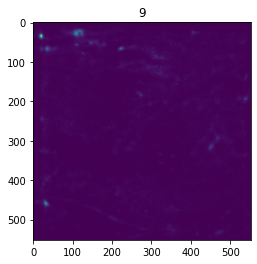

In [4]:
blind_rl.predict(args['source_folder'], 10, 5, 3, 2, eval_img_steps = False, save_intermediate_res= True, planes_padding=10)

*Compute metrics*

In [22]:
metrics = iqm.ImageQualityMetrics()

img_name = 'Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif'
psf_name = 'Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2_psf.tif'
path = 'C:/Users/Johan/Documents/FAU_Masterarbeit/Implementation/Blind_RL'

original_path = 'C:/Users/Johan/Documents/FAU_Masterarbeit/Implementation/Registered/Raw'
org = tif.imread(os.path.join(original_path, img_name))
org_sm = blind_rl.preprocess(org, 2)

result = []

for k in range(0,11):
    i_n = 'iter_' + str(k) + img_name
    p_n =  'iter_' + str(k) + psf_name

    img = tif.imread(os.path.join(path,i_n))
    psf = tif.imread(os.path.join(path, p_n))
    convolved = convolve(img, psf, mode='same')
    result.append(metrics.compute_all(org_sm, convolved))

### 2.2.2 Plot result

In [48]:
import matplotlib as mat
mat.rc_file_defaults()

Text(0.5, 1.0, 'SSIM')

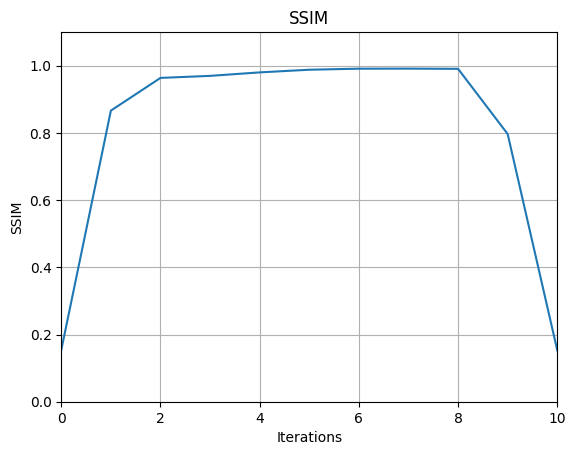

In [55]:
met_ssim = [x['ssim'] for x in result]

plt.plot(np.arange(0,11), met_ssim)
plt.xlim(0,10)
plt.ylim(0,1.1)
plt.grid()
plt.xlabel( 'Iterations')
plt.ylabel( 'SSIM')

plt.title('SSIM')

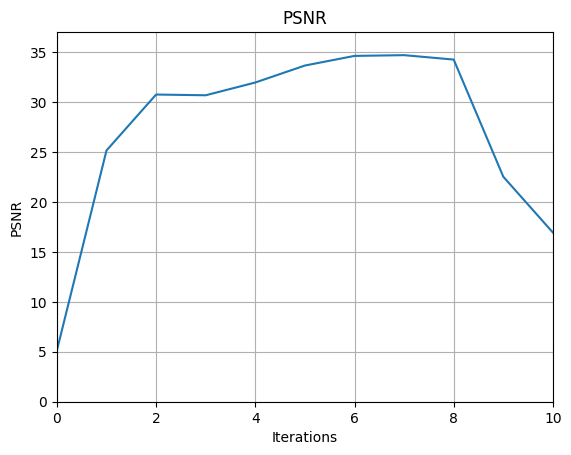

In [53]:
met_psnr = [x['psnr'] for x in result]

plt.plot(np.arange(0,11), met_psnr)
plt.xlim(0,10)
plt.ylim(0,37)
plt.title('PSNR')
plt.xlabel( 'Iterations')
plt.ylabel( 'PSNR')

plt.grid()

In [26]:
met_psnr

[5.13981320194241,
 25.154258125170927,
 30.751667997145763,
 30.678342879542512,
 31.95574485757312,
 33.65525944051614,
 34.620264511225336,
 34.693751480427856,
 34.251692758656446,
 22.52450865155362,
 16.934688223044102]

Text(0.5, 1.0, 'MSE')

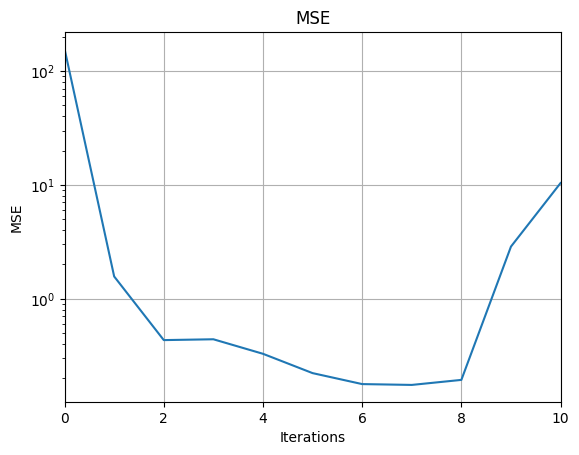

In [54]:
met_mse = [x['mse'] for x in result]

plt.plot(np.arange(0,11), met_mse[0:])
plt.xlim(0,10)
plt.grid()
plt.yscale('log')
plt.xlabel( 'Iterations')
plt.ylabel( 'MSE')

plt.title('MSE')

In [ ]:
# TODO: decide for best parameter combination

## 3. Exemplary images compared to GT provided by AutoQuant

* Overlay images

# Archiv

### *How does sigma effect SNR?*
* Load all Train (Raw32) data
* Calc SNR
* Smooth with certain sigma
* Clac SNR
* Same with different sigma

In [3]:
# full DS
path= 'd:/jo77pihe/Registered/Raw_32'
files = [f for f in os.listdir(path) if f.endswith('.tif')]
deconvolver = REGISTRY['BlindRL'](args)
sigma = np.arange(0 ,4.1, 0.5)
s_str = ['σ=' +str(elem) for elem in sigma]

metrics = iqm.ImageQualityMetrics()

res=np.zeros((len(files),len(sigma)))

for (i, f) in enumerate(files):
    for (j, s) in enumerate(sigma):
        img = np.float32(io.imread(os.path.join(path, f)))
        ix=deconvolver.preprocess(img, s)
        res[i,j] = metrics.snr(ix)

In [33]:
df = pd.DataFrame(data=res,index=files, columns=s_str)
df['F_name'] =files

In [34]:
df.head()

,σ=0.0,σ=0.5,σ=1.0,σ=1.5,σ=2.0,σ=2.5,σ=3.0,σ=3.5,σ=4.0,F_name
Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2.tif,1.611228,1.053162,0.957754,0.981481,1.001684,1.022587,1.045148,1.068498,1.091991,Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_201...
Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A3.tif,1.559319,0.996768,0.812810,0.832253,0.857906,0.885794,0.915714,0.947201,0.979811,Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_201...
Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A4.tif,1.348308,0.792429,0.708131,0.697736,0.711773,0.729630,0.748927,0.769338,0.790583,Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_201...
Alessandro_443_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-09-16_A2.tif,1.951805,0.919334,0.781777,0.753131,0.763302,0.788424,0.814246,0.839553,0.863166,Alessandro_443_ArcCreERT2_Thy1GFP_Ai9_TRAP_201...
Alessandro_443_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-09-16_A3.tif,1.440021,0.795229,0.684454,0.654361,0.672977,0.693722,0.716310,0.740294,0.765274,Alessandro_443_ArcCreERT2_Thy1GFP_Ai9_TRAP_201...


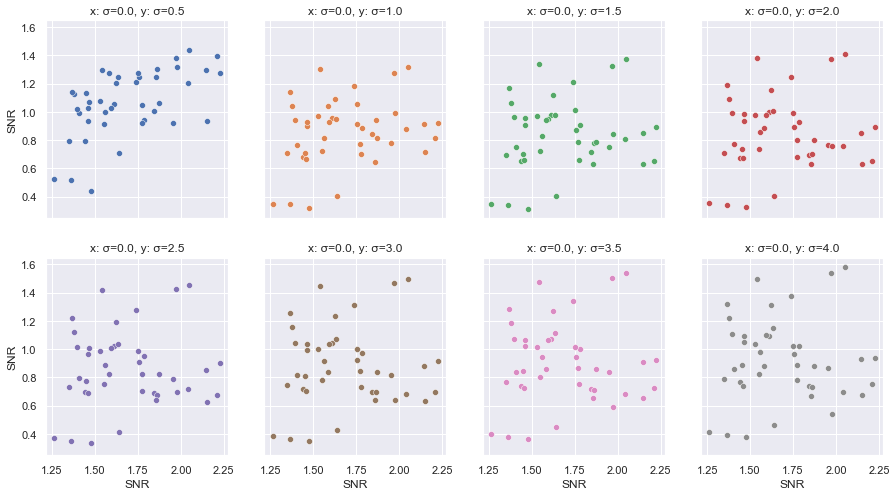

In [72]:
fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(15,8))

sns.set()
x_vals= s_str[1:]
for (i, x) in enumerate(x_vals):
    # axes[i//3,i%3]=
    color = 'C' + str(i)
    sns.scatterplot(ax=axes[i//4,i%4], data=df, x="σ=0.0", y=x_vals[i], color=color)
    axes[i//4,i%4].set_title('x: σ=0.0, y: ' +x)
    if i%4==0:
        axes[i//4,i%4].set_ylabel('SNR')
    if i//4 ==1:
        axes[i//4,i%4].set_xlabel('SNR')

# plt.legend(labels=x_vals)

### *Indicate what image is where*

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

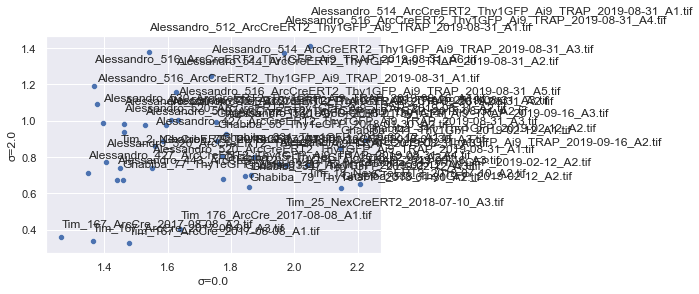

In [45]:
sns.scatterplot( data=df, x="σ=0.0", y="σ=2.0")
label_point(df["σ=0.0"], df[x_vals[i]], df['F_name'], plt.gca())

*How is the initial SNR? Same for all images?*

## Computational complexity

To optimize the computational complexity it is evaluated whether using the several CPU cores is better suited for this problem or using the GPU.

In [ ]:
files = [f for f in os.listdir('.\\Registered') if f.endswith('.tif')]

for i in range(3):
    X = io.imread(os.path.join('.\\Registered', files[i]))
    X = np.float32(X)
    X -=np.min(X)
    X /= np.max(X)

    psf = np.float32(_get_psf(X.shape[1]+40, X.shape[0]+10))

    # Variante 4:
    start = timeit.default_timer()
    xt = cupy.array(X)
    xt =cupy.pad(xt, ((10, 10), (20, 20), (20, 20)), 'reflect')
    stop_1 =timeit.default_timer()
    print( 'Option 4 preprocessing took ' + str(stop_1-start) +' s')
    start_1 = timeit.default_timer()
    res = ndimage.convolve(xt, cupy.array(psf), mode='constant')
    stop = timeit.default_timer()
    print( 'Option 4 (cupyx.scipy.ndimage.convolve) took ' + str(stop-start_1) +' s')

    start_2 = timeit.default_timer()
    (z, x, y) = res.shape
    res= res[10:z - 10, 20:x - 20, 20:y - 20]
    n_a = cupy.asnumpy(res)
    stop_2 = timeit.default_timer()
    print( 'GPU to CPU took ' + str(stop_2-start_2) +' s')
    print( 'Cupy total ' + str(stop_2-start) +' s')

    X = _pad(X)
    # Variante 2:
    start = timeit.default_timer()
    conv_2 = convolve(X, psf, 'same')
    stop = timeit.default_timer()
    print('Option 2 (scipy.signal.convolve) took ' + str(stop - start) + ' s')

    # Variante 3:
    start = timeit.default_timer()
    conv_3 = fftconvolve(X, psf, 'same')
    stop = timeit.default_timer()
    print('Option 3 (scipy.signal.fftconvolve) took ' + str(stop - start) + ' s')

Option 4 preprocessing took 0.9333463000000002 s <br />
Option 4 (cupyx.scipy.ndimage.convolve) took 0.12264259999999982 s <br />
GPU to CPU took 327.6718962 s <br />
Cupy total 328.72917820000004 s <br />
Option 2 (scipy.signal.convolve) took 10.591252199999985 s <br />
Option 3 (scipy.signal.fftconvolve) took 10.646289299999978 s <br />
Option 4 preprocessing took 0.029377599999975246 s <br />
Option 4 (cupyx.scipy.ndimage.convolve) took 0.06829340000001594 s <br />
GPU to CPU took 500.137793 s <br />
Cupy total 500.2367078 s <br />
Option 2 (scipy.signal.convolve) took 12.685107899999934 s <br />
Option 3 (scipy.signal.fftconvolve) took 12.907299499999908 s <br />
Option 4 preprocessing took 0.057668700000022 s <br />
Option 4 (cupyx.scipy.ndimage.convolve) took 0.8614688999999771 s <br />
GPU to CPU took 1140.3189865 s <br />
Cupy total 1141.2392298 s <br />
Option 2 (scipy.signal.convolve) took 18.53494929999988 s <br />
Option 3 (scipy.signal.fftconvolve) took 18.675417900000184 s <br />

## Test whether 2 PSFs required

One for odd and one for even numbers

In [2]:
import multiprocessing

multiprocessing.freeze_support()

In [2]:
args = {}
args['data_path']= ''
args['source_folder']= '../Registered/Heatmap'
args['target_folder']= ''
args['result_path'] = 'Blind_RL_PSF_planes'
args['test_flag'] = True

args['psf'] = "../PSF"

blind_rl = deconv.BlindRL(args)
blind_rl.predict(args['source_folder'], 7, 5, 3, 2, eval_img_steps = False, save_intermediate_res= False, parallel=False)

In [3]:
args['test_flag'] = False

blind_rl = deconv.BlindRL(args)
blind_rl.predict(args['source_folder'], 7, 5, 3, 2, eval_img_steps = False, save_intermediate_res= False, parallel=False)

In [ ]:
files = [f for f in os.listdir('.\\Blind_RL_PSF_planes') if f.endswith('.tif')]

X_t1 = io.imread(os.path.join('.\\Blind_RL_PSF_planes', files[0]))
X_t2 = io.imread(os.path.join('.\\Blind_RL_PSF_planes', files[1]))

In [ ]:
np.allclose(X_t1, X_t2)